# DFTI Experiment

The Boxcoxrox project utilizies the DFTI approach for categorizing reviews into high level groupings.  Unlike LDA, which uses product reviews  and an unsupervised learning approach, DFTI is a supervised learning approach that starts with a pre-set list of categories and key words.  The approach then counts the occurance of keywords in documents, and then uses an argmax approach to identify selected topics.  The DFTI approach is explained more fully in the DFTI notebook.  The purpose of this notebook is to estimate the accuracy of the approach.

We begin by creating a list of know categories:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

def get_bcr_categories():
    cat_df = pd.read_csv('category.csv')
    categories = pd.DataFrame(cat_df.groupby('category').count()['asin'])
    categories.columns = ['count']
    #print(cat_counts)
    #categories = list(set(cat_df['category'].values))
    return categories


categories = get_bcr_categories()
categories

,count
category,
amphibians and reptiles,2708
bird,6223
cat,24710
dog,95392
farm animals,3814
fish,8324
other,46134
rabbits and rodents,11097


Next we create a sample of 20 products from each category.

In [2]:
def get_category_sample(category, n):
    prod_df = pd.read_csv("pet_products_all.csv")
    cat_df = pd.read_csv('category.csv')
    cat_df['bcr_category'] = cat_df['category']
    cat_df.drop(['category'], inplace=True, axis=1)
    cat_df = cat_df[cat_df['bcr_category']==category].sample(n)
    products = cat_df.merge(prod_df, on='asin')
    return products
    
get_category_sample("dog", 20)

FileNotFoundError: [Errno 2] No such file or directory: 'pet_products_all.csv'

The following cell defines a function that verifies that a DFTI category name appears either in the amazon categorization or the the product title.  

In [ ]:
def clean_txt(s):
    s = str(s).lower()
    c = "".join([x for x in s if x.isalpha() or x==" "])
    return c

def col_check(row, key, targets):
    result = 0
    
    for target in targets:
        if row[key].lower() in clean_txt(row[target]):
            result=1
    return result

def check_categorization(df, key, targets):
    df['check'] = df.apply(lambda row: col_check(row, key, targets), axis=1)    
    return df


    

The cell below picks 20 random products from each category, and then computes the accuracy for each.  The final results are displayed in a bar braph.

In [ ]:
n = 20
accuracy = {}
full_checked = None
for idx, row in categories.iterrows():
    category = idx
    df = get_category_sample(category, n)
    checked_df = check_categorization(df, 'bcr_category', ['title','category'])
    if full_checked is None:
        full_checked = checked_df.copy()
    else:
        full_checked = pd.concat([full_checked, checked_df])

        
        
def save_cleaned_df(df):
    df['title'] = df.apply(lambda row: clean_txt(row['title']), axis=1)
    df['category'] = df.apply(lambda row: clean_txt(row['category']), axis=1)
    df['description'] = df.apply(lambda row: clean_txt(row['description']), axis=1)
    df.to_csv('Full_Checked_DF_Precheck.csv', index=False)
    
    
    
save_cleaned_df(full_checked)

print("Full Checked Saved.")

Unfortunately, due to the nature of the data, the check above is not 100% accurate.  As a result, the Full_Checked_DF_Precheck.csv file above was copied to Full_Check_DF.csv and then manually verified.  That file is loaded below, and the accuracy of the different categories are displayed on a barchart.

Overall Weighted Accuracy: 0.7777272057465859


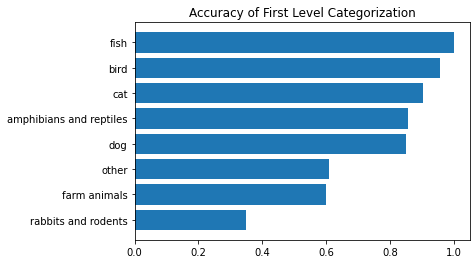

In [25]:
all_check_df = pd.read_csv('Full_Checked_DF.csv')
all_check_df
overall_weighted_accuracy = 0
accuracy = []
cat_list = []
N = sum(categories['count'])
for idx, row in categories.iterrows():
    category = idx
    check_df = all_check_df[all_check_df['bcr_category']==category]
    acc = sum(check_df['check'])/len(check_df)
    cat_count = row['count']
    weighted = acc * cat_count/N
    accuracy.append(acc)
    cat_list.append(row.name)
    overall_weighted_accuracy = overall_weighted_accuracy + weighted

  
acc_index = np.argsort(accuracy)    
ordered_acc = [accuracy[i] for i in acc_index]
ordered_cat = [cat_list[i] for i in acc_index]
plt.barh(ordered_cat, ordered_acc)
plt.title('Accuracy of First Level Categorization')
print("Overall Weighted Accuracy: {}".format(overall_weighted_accuracy))
